In [2]:
import site

site.addsitedir("..")

import pandas as pd
from tqdm import tqdm

import cpp_game
from src.ai.rollout import do_batch_rollout_cpp
from src.game.settings import Settings
from src.game.tasks import TASK_DEFS

In [3]:
num_tasks = len(TASK_DEFS)

rows = []
for task_idx in tqdm(range(num_tasks)):
    settings = Settings(
        use_signals=False, bank="all", task_distro="random", task_idxs=(task_idx,)
    )
    cpp_settings = settings.to_cpp()
    num_rollouts = 200
    batch_rollout = cpp_game.BatchRollout(cpp_settings, num_rollouts)

    td = do_batch_rollout_cpp(batch_rollout, batch_seed=42, device="cpu")
    mean_reward = td["rewards"].sum(dim=1).mean().item()
    win_rate = td["win"].float().mean().item()
    formula, _, difficulty = TASK_DEFS[task_idx]
    rows.append(
        dict(
            task_idx=task_idx,
            formula=formula,
            difficulty=difficulty,
            mean_reward=mean_reward,
            win_rate=win_rate,
        )
    )

df = pd.DataFrame(rows)

100%|██████████| 91/91 [00:10<00:00,  8.91it/s]


<Axes: ylabel='Frequency'>

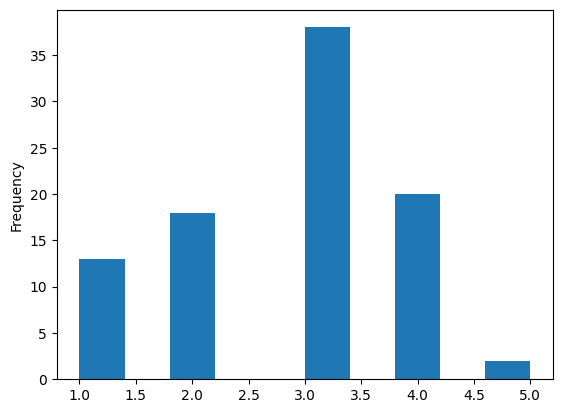

In [4]:
df["difficulty"].plot.hist()

<Axes: xlabel='mean_reward'>

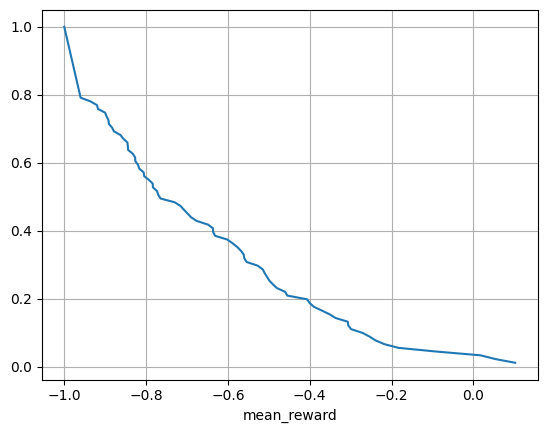

In [5]:
df.groupby("mean_reward").size().pipe(lambda df: df[::-1].cumsum() / df.sum()).plot(
    grid=True
)

<Axes: xlabel='win_rate'>

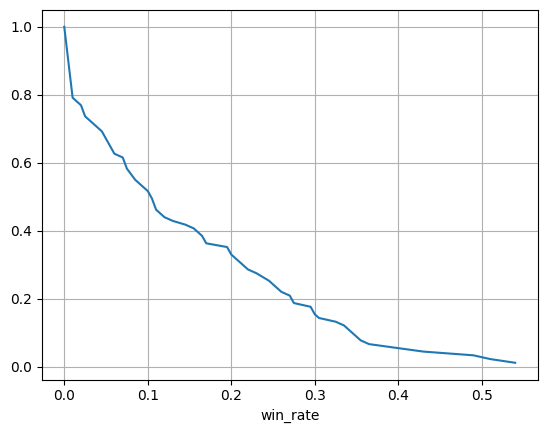

In [6]:
df.groupby("win_rate").size().pipe(lambda df: df[::-1].cumsum() / df.sum()).plot(
    grid=True
)

In [10]:
med_df = df.query("win_rate >= 0.2 and difficulty <= 3")
task_idxs = med_df["task_idx"].to_list()
med_task_defs = [TASK_DEFS[i] for i in task_idxs]
print(med_task_defs)
print()

print("{" + ", ".join(f'{{"{x}", "{y}", {z}}}' for x, y, z in med_task_defs) + "};")

[('6g', 'I will win 6g', 1), ('#7>=2', "I will win at least 2 7's.", 2), ('#T=2', 'I will win exactly 2 tricks.', 2), ('#t=0', 'I will win no submarines.', 1), ('T-1', 'I will win the last trick.', 3), ('3p', 'I will win 3p.', 1), ('consec(3)', 'I will win 3 tricks in a row.', 3), ('no(T0) no(T1) no(T2)', 'I will win none of the first 3 tricks.', 2), ('#p>=1 #g>=1 #y>=1 #b>=1', 'I will win at least one card of each color.', 3), ('#5=0', 'I will no 5', 2), ('3t', 'I will win 3t.', 1), ('T0', 'I will win the first trick.', 1), ('1y', 'I will win 1y.', 1), ('#T>#T(anyother)', 'I will win more tricks than anyone else.', 3), ('#p=0', 'I will win no pink.', 2), ('consec(2)', 'I will win 2 tricks in a row.', 1), ('#9=2', "I will win exactly 2 9's.", 3), ('nolead(y,p,b)', 'I will not open a trick with yellow, pink, or blue.', 3), ('#p>#g', 'I will win more pink than green cards. 0 green cards is allowed.', 1), ('#p=0 #b=0', 'I will win no pink or blues.', 3), ('no(consec(2))', 'I will never wi